In [1]:
import gc
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import lightgbm as lgb
import matplotlib.pyplot as plt

In [2]:
auctions = pd.read_csv('auctions.csv')
clicks = pd.read_csv('clicks.csv')
events = pd.read_csv('events.csv')
installs = pd.read_csv('installs.csv')
target_competencia = pd.read_csv('target_competencia.csv')

c:\users\ignacio\appdata\local\programs\python\python37\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (12,18,19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
auctions.head()

,auction_type_id,country,date,device_id,platform,ref_type_id,source_id
0,NaN,6333597102633388268,2019-03-11 14:18:33.290763,6059599345986491085,1,1,0
1,NaN,6333597102633388268,2019-03-11 14:18:34.440157,1115994996230693426,1,1,0
2,NaN,6333597102633388268,2019-03-11 14:18:35.862360,7463856250762200923,1,1,0
3,NaN,6333597102633388268,2019-03-11 14:18:36.167163,7829815350267792040,1,1,0
4,NaN,6333597102633388268,2019-03-11 14:18:37.728590,1448534231953777480,1,1,0


In [4]:
auctions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19571319 entries, 0 to 19571318
Data columns (total 7 columns):
auction_type_id    float64
country            int64
date               object
device_id          int64
platform           int64
ref_type_id        int64
source_id          int64
dtypes: float64(1), int64(5), object(1)
memory usage: 1.0+ GB


In [5]:
auctions.isnull().sum()

auction_type_id    19571319
country                   0
date                      0
device_id                 0
platform                  0
ref_type_id               0
source_id                 0
dtype: int64

In [6]:
auctions.drop('auction_type_id', axis=1, inplace=True)

In [7]:
auctions['date'] = pd.to_datetime(auctions['date'])

In [8]:
print('Rango fechas: ')
print(str(auctions['date'].min()))
print(str(auctions['date'].max()))

Rango fechas: 
2019-03-05 00:52:33.352526
2019-03-13 23:59:59.997032


In [9]:
auctions['day'] = auctions['date'].transform(lambda x : x.day)

In [10]:
auctions['hour'] = auctions['date'].transform(lambda x : x.hour)

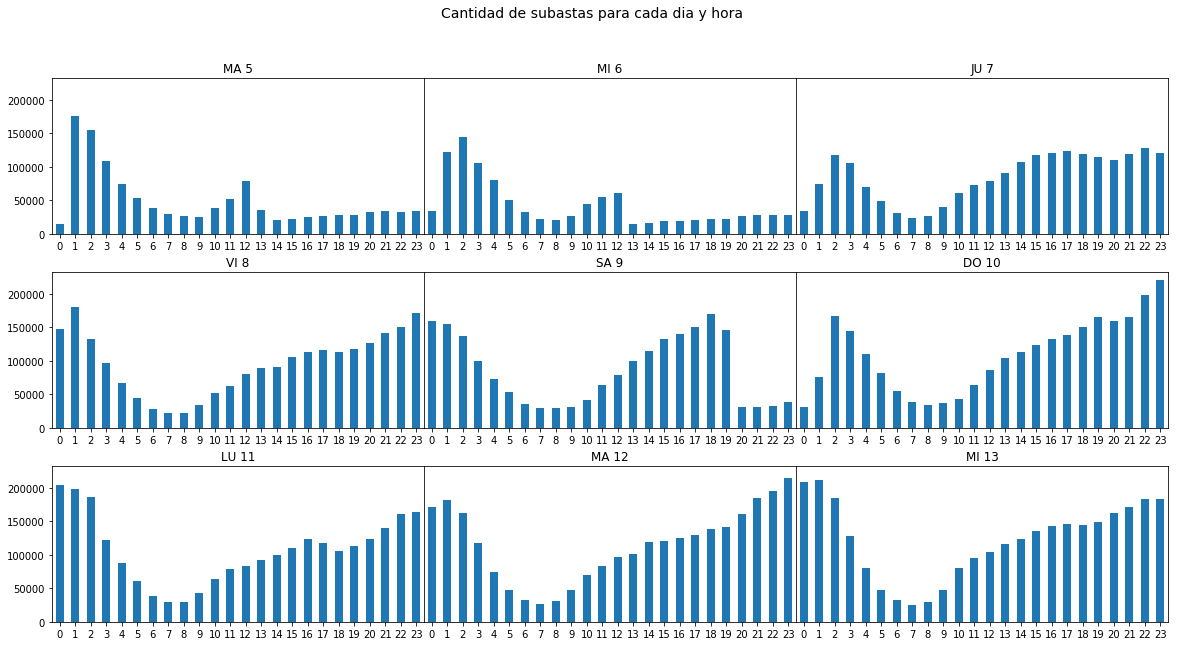

In [11]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(20,10))
ax = ax.flatten()

fig.suptitle("Cantidad de subastas para cada dia y hora", fontsize=14)
plt.subplots_adjust(wspace=0, hspace=0.25)

diasDeLaSemana = ['LU', 'MA', 'MI', 'JU', 'VI', 'SA', 'DO']

for idx, gp in auctions.groupby('day'):
    idx -= 5
    ax[idx].set_title(str(diasDeLaSemana[gp['date'].iloc[0].dayofweek]) + ' ' + str(gp['day'].iloc[0]))
    
    gp.groupby(gp['hour']).size().rename_axis([None]).to_frame().reindex(np.arange(0,24,1))\
        .plot(kind='bar', ax=ax[idx], rot=0, legend=False)
    
    if idx%3 != 0:
        ax[idx].get_yaxis().set_visible(False)

        
lb, ub = list(zip(*[axis.get_ylim() for axis in ax]))
for axis in ax:
    axis.set_ylim(min(lb), max(ub)) 

plt.show()